# Final Figures for PIK3CA Story
### Phosphorylation levels

### Standard Imports

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import json
import operator

#import the Endometrial data from CPTAC package
import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. This import contains
information about the package. In order to access a specific data set,
import a CPTAC subfolder by either 'import CPTAC.DataName' or 'from
CPTAC import DataName'.
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


### Get phosphorylation data and somatic mutations from CPTAC

In [2]:
somatic = CPTAC.get_somatic()
phos = CPTAC.get_phosphoproteomics()

### Make Phosphoproteomics box plot for AKT1, AKT2, PTEN, PIK3CA
##### Show data for hotspot mutations vs all other mutations or wildtype

In [37]:
'''Use PIK3CA as gene, AKT1, AKT2, PTEN, and PIK3CA as proteins'''
gene = 'PIK3CA'
protList = ['AKT1','AKT2','PTEN','PIK3CA']

'''A list of mutations present in the hotspot according to our Hotspot3D output'''
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

'''Get the PIK3CA mutation dataframe'''
plotdf = CPTAC.compare_mutations(phos, gene)

'''Look only at Tumor patients'''
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]

'''Add in the protein levels for every protein in the list'''
for protein in protList:
    proteindf = CPTAC.compare_mutations(phos, protein, gene)
    proteindf = proteindf.loc[proteindf['Patient_Type'] == 'Tumor']
    for site in proteindf:
        if site != 'Mutation' and site != 'Patient_Type':
            plotdf = plotdf.join(proteindf[site])
            
            
'''Reformat the dataframe to classify Hotspot Mutations, and all other types'''
for ind, row in plotdf.iterrows():
    if ind in hotspot_patients.values:
        plotdf.at[ind, 'Mutation'] = 'Hotspot Mutation'
    else:
        plotdf.at[ind, 'Mutation'] = 'Non-Hotspot Mutation or Wildtype'

#print(plotdf)
significance_of_sites = {}
for site in plotdf:
    if site != 'Mutation':
        hotspotdf = plotdf.loc[plotdf['Mutation'] == 'Hotspot Mutation'][['Mutation', site]]
        hotspotdf = hotspotdf.dropna(axis=0)
        otherdf = plotdf.loc[plotdf['Mutation'] != 'Hotspot Mutation'][['Mutation', site]]
        otherdf = otherdf.dropna(axis=0)
        ttest = scipy.stats.ttest_ind(hotspotdf[site], otherdf[site])
        significance_of_sites[site]=ttest[1]

#print(significance_of_sites)
mostSignificantPhosphorylationSites = ['Mutation','AKT1S1-S267','AKT2-T451','PTEN-S558','PIK3CA-T313']
plotdf = plotdf[mostSignificantPhosphorylationSites]
#print(plotdf)

plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Phosphorylation Site', value_name='Signal')
plotdf = plotdf.dropna(axis=0)

'''Create the plot'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Hotspot Mutation": "#009933", "Non-Hotspot Mutation or Wildtype": "#008ae6"}
boxplt = sns.boxplot(x='Phosphorylation Site', y='Signal', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Phosphorylation Site', y='Signal', hue='Mutation', dodge=True, jitter=True, color='.3')
boxplt.set_xlabel('')
boxplt.set_ylabel('Phosphorylation Level', fontsize='60')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation in PIK3CA Interacting Proteins', fontsize = '75')

'''Adjust the legend'''
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Hotspot Mutation', 'Non-Hotspot Mutation or Wildtype'], title='PIK3CA Status', fontsize='30', frameon=True)
boxplt.get_legend().get_title().set_fontsize('25')

'''Show Plot'''
fig = boxplt.get_figure()
plt.show()

{'AKT1-S122': 0.5054404997224948, 'AKT1-S124': 0.6706774689768096, 'AKT1-S126': 0.7527767230674126, 'AKT1-S129': 0.6225282061459592, 'AKT1-T450': 0.9137549205077822, 'AKT1S1-S108': 0.33482696618643604, 'AKT1S1-S112': 0.4915096035432561, 'AKT1S1-S203': 0.4229849931760118, 'AKT1S1-S222': 0.40990754364672066, 'AKT1S1-S223': 0.5472780915404707, 'AKT1S1-S231': 0.15963014107690238, 'AKT1S1-S232': 0.890724203697261, 'AKT1S1-S241': nan, 'AKT1S1-S267': 0.04216847008360616, 'AKT1S1-T110': 0.2400056584968401, 'AKT1S1-T117': 0.41537520386103965, 'AKT1S1-T218': nan, 'AKT1S1-T266': 0.9841656518510405, 'AKT1S1-T93': 0.5183642157349828, 'AKT2-S126': 0.7865526110086466, 'AKT2-S128': 0.4675860563082218, 'AKT2-S302': nan, 'AKT2-S34': 0.5070598681158256, 'AKT2-S474': nan, 'AKT2-T133': nan, 'AKT2-T449': 0.370678445218241, 'AKT2-T451': 0.24274206372627125, 'PTEN-S467': 0.5573473385330219, 'PTEN-S475': 0.6043352102652493, 'PTEN-S478': 0.24621432586434788, 'PTEN-S537': 0.5400540531400972, 'PTEN-S543': 0.71296

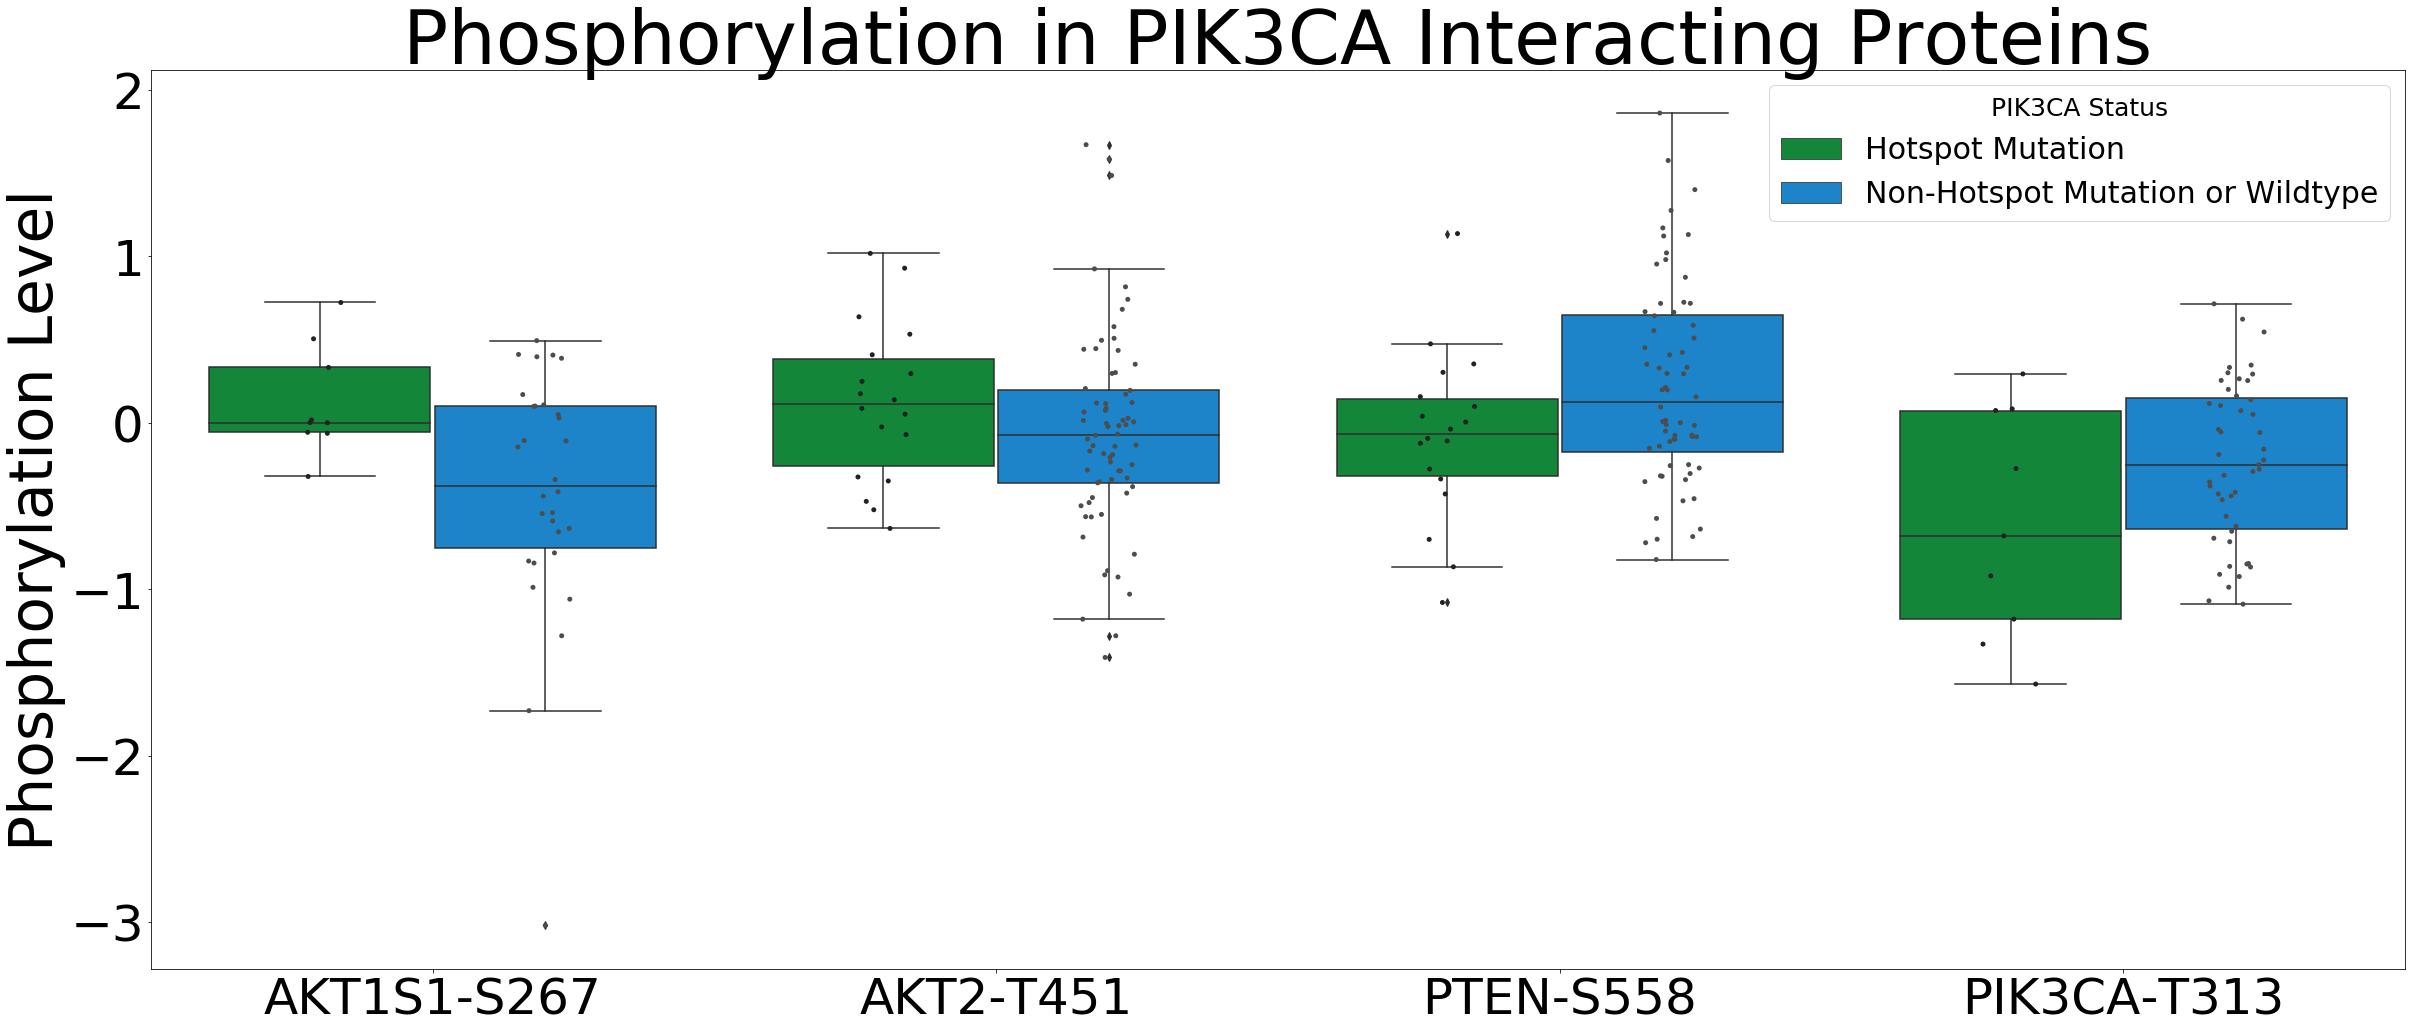